# Turborreactor con Postcombustor:
Se tiene un caza equipado con dos turborreactores como el de la figura, compuesto cada uno de ellos por un generador de gas, una turbina y compresor de baja, un difusor, un postcombustor tras la turbina de baja y una tobera final. La cámara de combustión y el postcombustor funcionan con JET-A1 ($L=42\frac{MJ}{kg}$). Del compresor de baja se sangra parte de la corriente para alimentar sistemas del caza (actuadores y antihielos), causando una disminución del 15% en $G_{25}$ respecto a $G_2$.

![Esquema](./Recursos/esquema_.png)

El caza se somete a una condición de vuelo de **320KIAS** a **21000ft** de altura en régimen estacionario y se mantiene el nivel de vuelo, sin postcombustor. A continuación, el piloto activa el postcombustor de los turborreactores durante 3 minutos, en los que alcanza un régimen estacionario de **450KIAS** a la vez que eleva la altitud en 12000ft.

Dada la información de la turbomáquina de la siguiente tabla

|      Difusor (2)     | Compresor Baja (25) | Compresor Alta (3)| Cámara de Combustión (4)|  Turbina Alta (45)|  Turbina Baja  (5)|   Jet Pipe  (6) | Post Combustor (7)|     Tobera   (9)  |
|:-------------:|:--------------:|:--------------:|:--------------------:|:-------------:|:--------------:|:------------:|:--------------:|:--------------:|
|$\eta_{D}=0.92$| $\eta_{C2}=0.8$|$\eta_{C1}=0.88$|$\eta_q=0.9 $         |$\eta_{T1}=0.9$|$\eta_{T2}=0.75$|              |$\eta_{q2}=0.9$   |$\eta_{TO}=0.95$|
|$\phi_1=0.75m$              |$\Pi_{C2}=3$    | $\Pi_{C1}=5 $  |$\Pi_{CC}=0.95$       |               |                |$\Pi_{65}=0.9 $|$\Pi_{76}=0.9$ |                |             
|               |       $G_{2}=G_{25}+G_{sang}$         |                |$L=42\frac{MJ}{kg}$; $f=0.02$  |               |                |              |$L=42\frac{MJ}{kg}$;$f=0.035$|                |                |

Asumiendo que la tobera está adaptada a la altitud de **21000ft**, se pide:
1. Resolver el empuje, T4t y p3t del turborreactor cuando se mantiene en régimen estacionario a 320KIAS
2. Resolver el empuje, T4t, p3t, p7t y T7t y cuando se enciende el postcombustor y se adquiere la velocidad de 450KIAS
3. Obtener el rendimiento motopropulsor en ambas condiciones de vuelo
4. Comparar el turborreactor calculado con el EJ200

---

## Datos e hipótesis:
* Se asumirá gas perfecto y ecuación de estado en cada etapa. El calor específico a presión constante se puede caracterizar para las tomas (difusor y tobera), compresión, expansión y cámaras de combustión según:

|           Tomas (Difusor y Tobera)          |         Compresión (Alta y baja)       |         Cámaras de Combustión        |         Expansión (Alta y Baja)         |
|:-------------------------:|:-------------------------:|:-------------------------:|:-------------------------:|
| $c_p=1000 \frac{J}{kg K}$ | $c_p=1050 \frac{J}{kg K}$ | $c_p=1170 \frac{J}{kg K}$ | $c_p=1090 \frac{J}{kg K}$ |

* Además de esto el aire tiene coeficiente de dilatación adiabática constantes y conocidos:
 * $\gamma_a=1.4$
 * $R_a=287\frac{J}{kg K}$.

* La combustión no se considerará diluida

* La corriente sangrada se puede considerar a la misma temperatura y presión de remanso que la corriente principal

### Datos del EJ200: 
Régimen máximo sin postcombustor y con postcombustor:
![EJ200](./Recursos/datosej200.png)

---

## Solución:

Para obtener la condición de vuelo inicial se hará uso de las funciones de presión y temperatura según Atmósfera Estándar Internacional contenidas en `ISA.py`. Se asumirá que $\Delta T_{ISA} = 0$.

Asimismo, para las relaciones de gas isoentrópico, número de Mach, etc. se usarán las funciones contenidas en `isentropic_gas.py`. Se hará uso de modelo de gas ideal.

In [1]:
import numpy as np # librería numérica
from matplotlib import pyplot as plt # librería para gráficas

import isa as int_std_atm #atmósfera estándar internacional
from isentropic_gas import IsentropicGas #relaciones gas isoentrópico
ideal_isent_gas = IsentropicGas(selected_cp_air_model='ideal', selected_gamma_air_model='ideal') 

### 1) Datos:
##### Aire:

In [2]:
# Constantes:
gamma_a = 1.4 #Adim.
Ra = 287 # J/kg/K

# Calores Específicos:
cp_d  = 1000 # J/kg/K
cp_to = 1000 # J/kg/K
cp_c1 = 1050 # J/kg/K
cp_c2 = 1050 # J/kg/K
cp_cc = 1170 # J/kg/K
cp_t1 = 1090 # J/kg/K
cp_t2 = 1090 # J/kg/K

In [3]:
# Datos iniciales:
h0 = 21000*0.3048 # m

p0 = int_std_atm.pres_isa(h=h0)
T0 = int_std_atm.temp_isa(h=h0, isa_dev=0)
v0 = 320*1852/3600;
print('Presión ambiente: {0:6.0f}Pa, Temperatura ambiente: {1:3.1f}K'.format(p0, T0))
print('Altitud: {0:5.1f}m, Velocidad de vuelo: {1:3.1f}m/s'.format(h0, v0))

Presión ambiente:  44740Pa, Temperatura ambiente: 246.5K
Altitud: 6400.8m, Velocidad de vuelo: 164.6m/s


##### Difusor, Tobera y Jet-Pipe:

In [4]:
# Rendimientos adiabáticos
eta_d = 0.92
eta_to = 0.95

# Condición de tobera adaptada:
p9 = p0

# Caída de presión en Jet-pipe:
pi_jp = 0.9

# Área de entrada al turborreactor:
A1 = np.pi*0.75**2/4 #m**2

##### Compresores de Alta y Baja:

In [5]:
# Rendimientos adiabáticos
eta_c2 = 0.80 # Compresor de baja
eta_c1 = 0.88 # Compresor de alta 

# Relación de compresión:
pi_c2   = 3    # Compresor de baja
pi_c1   = 5    # Compresor de baja

# Compresor 1 acoplada mecánicamente a T1 (N1)
# Compresor 2 acoplada mecánicamente a T2 (N2)

##### Cámara de Combustión y Postcombustor

In [6]:
# Rendimiento Adiabático:
eta_q = 0.90  # Cámara de combustión
eta_pc = 0.90 # Postcombustor

# Caída de presión
pi_cc = 0.95  # Cámara de combustión
pi_pc = 0.90  # Postcombustor

# Poder calorífico JET-A1
L = 42*1e6 #J/kg

# Dosado de la mezcla:
f_cc = 0.02   # Cámara de combustión
f_pc = 0.035  # Postcombustor

##### Turbinas de Alta y Baja:

In [7]:
# Rendimientos adiabáticos
eta_t2 = 0.90 # Turbina de baja
eta_t1 = 0.75 # Turbina de alta

# Turbina 1 acoplada mecánicamente a C1 (N1)
# Turbina 2 acoplada mecánicamente a C2 (N2)

### 2) Rendimientos Adiabáticos:

De las expresiones de los rendimientos adiabáticos de difusor, compresor, turbina y tobera, se despeja en cada caso la variable deseada (T3t en compresores, p5t en Turbinas, T9 en tobera).

$$ \eta_d=\frac{{\left(\frac{p_{2t}}{p_{1}}\right)^{\frac{\gamma-1}{\gamma}}-1}}{\frac{T_{2t}}{T_{1}}-1}$$

$$ \eta_c=\frac{{\Pi_{32}}^{\frac{\gamma-1}{\gamma}}-1}{\frac{T_{3t}}{T_{2t}}-1}$$

$$ \eta_t=\frac{\frac{T_{5t}}{T_{4t}}-1}{\left(\frac{p_{5t}}{p_{4t}}\right)^{\frac{\gamma-1}{\gamma}}-1}$$

$$ \eta_{to}=\frac{\frac{T_{9}}{T_{7t}}-1}{\left(\frac{p_{9}}{p_{7t}}\right)^{\frac{\gamma-1}{\gamma}}-1}$$

In [8]:
## Presión fin de compresión dinámica:
def relPres_rend_dif(rend_d, rel_temp, gamma_a=1.4):
    aux1 = (rel_temp - 1) * rend_d + 1
    p2t_p1t = aux1 **(gamma_a/(gamma_a-1))
    return p2t_p1t

## Temperatura fin de compresión:
def relTemp_rend_comp(rend_c, rel_comp , gamma_a=1.4):
    aux1 = rel_comp**((gamma_a-1)/gamma_a) - 1
    T3t_T2t = 1 + (1/rend_c) * (aux1)
    return T3t_T2t

## Presión fin de expansión:
def relPres_rend_turb(rend_t, rel_temp , gamma_a=1.4):
    aux1 = (rel_temp - 1)/rend_t + 1
    p5t_p4t = aux1**(gamma_a/(gamma_a-1))
    return p5t_p4t

## Temperatura estática en salida del turborreactor:
def relTemp_rend_tob(rend_to, rel_comp, gamma_a=1.4):
    aux1 = rel_comp ** ((gamma_a-1)/gamma_a) - 1
    T9_T7t = rend_to * aux1 + 1
    return T9_T7t

### 3) Cálculo de Actuaciones:

$$E=G_9v_9 - G_1v_1 + A_9\left(p_9-p_0\right)\approx G_9v_9 - G_1v_1$$

$$I_{sp}=\frac{E}{G_9} = v_9 - \frac{G_1}{G_9}v_1$$

$$\eta_m=\frac{W_m}{W_c}=\frac{\left(G_0+c\right)v_9^2 - G_0v_0}{2cL} $$

$$\eta_p=\frac{W_u}{W_m}=\frac{2v_0\left[\left(G_0+c\right)v_9-G_0v_0\right]}{\left(G_0+c\right)v_9^2 - G_0v_0}$$

$$\eta_mp=\frac{W_u}{W_c}=\frac{v_0\left[\left(G_0+c\right)v_9-G_0v_0\right]}{cL}$$

$$c_E=\frac{E}{c}\approx \frac{G_9v_9 - G_1v_1}{c}\approx \left(\frac{1+f}{f}\right)v_9- \frac{1}{f}v_1$$

In [9]:
## Empuje:
def empuje(Gs, vs, G0, v0, A9=0, ps=0, p9=0):
    return Gs*vs - G0*v0 + A9*(p9-ps)

## Impulso:
def impulso(E, G):
    return E/G

## Consumo Específico:
def consumo_especifico(c,E):
    return c/E

## Rendimiento Motor:
def rend_motor(G9, G0, v9, v0, c, L):
    return (G9*v9**2 - G0*v0**2)/(2*c*L)

## Rendimiento Propulsor:
def rend_propulsor(G9, G0, v9, v0):
    return 2*v0*(G0*v9-G0*v0)/(G9*v9**2 - G0*v0**2)

## Rendimiento Motopropulsor:
def rend_motopropulsor(G9, G0, v9, v0, c, L):
    rendimiento = rend_motor(G9, G0, v9, v0, c, L) * rend_propulsor(G9, G0, v9, v0)
    return rendimiento

## Rendimientos agrupados:
def rendimientos(G9, G0, v9, v0, c, L):
    eta_m = rend_motor(G9, G0, v9, v0, c, L)
    eta_p = rend_propulsor(G9, G0, v9, v0)
    eta_mp = rend_motopropulsor(G9, G0, v9, v0, c, L)
    return eta_m, eta_p, eta_mp

### 4) Resolución sin Postcombustor encendido:

#### Solución del Difusor:

In [10]:
# Corriente libre (aguas arriba del avión):
M0 = ideal_isent_gas.mach_number(static_temperature=T0, velocity=v0)
T0t = ideal_isent_gas.stagnation_temperature_from_mach(mach=M0, static_temperature=T0)
p0t = ideal_isent_gas.stagnation_pressure_from_mach(mach=M0, static_pressure=p0, static_temperature=T0)

# Solución de la Toma (entrada limpia):
p1t = p0t; T1t=T0t
p1 = p0; T1 = T0

v1 = v0
rho1 = p1/Ra/T1
G1 = rho1*A1*v1

# Salida del difusor:
G2 = G1
T2t = T1t # Difusor isoentálpico
p2t = p1t*relPres_rend_dif(rend_d=eta_d, rel_temp=T2t/T1, gamma_a=gamma_a)
pi21 = p2t/p1t

# Balance de Energía:
H0t = G1 * cp_d * T0t
H1t = G1 * cp_d * T1t
H2t = G2 * cp_d * T2t

#### Solución del Compresor de Baja:

In [11]:
# Salida del compresor de Baja:
Gsang = G2*0.15
G25 = G2 - Gsang
p25t = p2t * pi_c2
T25t = T2t*relTemp_rend_comp(rend_c=eta_c2, rel_comp=pi_c2, gamma_a=gamma_a)

# Balance de Energía:
H25t = G25 * cp_c2 * T25t

# Primer Principio:
W_c2 = H25t - H2t

#### Solución del Compresor de Alta:

In [12]:
# Salida del compresor de Alta:
G3 = G25
p3t = p25t * pi_c1
T3t = T25t * relTemp_rend_comp(rend_c=eta_c1, rel_comp=pi_c1, gamma_a=gamma_a)

# Balance de Energía:
H3t = G3 * cp_c2 * T3t

# Primer Principio:
W_c1 = H3t - H25t

#### Solución de Cámara de Combustión:

In [13]:
# Gasto de combustible y de Aire:
c = f_cc * G3
G4 = G3 + c

# Potencia Calorífica de la combustión:
Q43 = eta_q * L * c

# Primer Principio a Cámara de Combustión:
T4t = (Q43 + H3t) / G4 / cp_cc

# Balance de Energía:
H4t = G4 * cp_cc * T4t

# Caída de presión:
p4t = p3t * pi_cc

#### Solución de Turbina de Alta:

In [14]:
# Gasto de la turbina de alta:
G45 = G4

# Primer Principio a la Turbina:
T45t = (H4t - W_c1)/G45/cp_t1
H45t = G45 * cp_t1 * T45t
W_t1 = H45t - H4t

# Caída de presión de la turbina de alta:
p45t = p4t * relPres_rend_turb(rend_t=eta_t1, rel_temp=T45t/T4t, gamma_a=gamma_a)

#### Solución de Turbina de Baja:

In [15]:
# Gasto de turbina de baja:
G5 = G45

# Primer Principio a la Turbina:
T5t = (H45t - W_c2)/G5/cp_t2
H5t = G5 * cp_t2 * T5t
W_t2 = H5t - H45t

# Caída de presión de la turbina de baja:
p5t = p45t * relPres_rend_turb(rend_t=eta_t2, rel_temp=T5t/T45t, gamma_a=gamma_a)

#### Solución del postcombustor (apagado):

In [16]:
# Gasto entre 5 y 7:
G6 = G5; G7 = G6

# Relación de presiones:
p6t = p5t * pi_jp
p7t = p6t * pi_pc

# Se asume, según el Primer Principio, que Jet-Pipe y Postcombustor son isoentálpicos (si pc está apagado)
T6t = H5t/G6/cp_t2
H6t = G6*cp_t2*T6t

T7t = H6t/G7/cp_t2
H7t = G7*cp_t2*T7t

#### Solución de la Tobera Adaptada:

In [17]:
# Gasto en la tobera:
G9 = G7

# Tobera adaptada:
p9 = p0

# Obtención de las temperaturas en la salida:
# Del Primer Principio: Tobera isoentálpica:
T9t = H7t/G9/cp_to
H9t = G9*cp_to*T9t
T9 = T7t*relTemp_rend_tob(rend_to=eta_to, rel_comp=p9/p7t, gamma_a=gamma_a)

# Presión de remanso en salida:
p9t = p9 * (T9t/T9)**(gamma_a/(gamma_a-1))

# Cálculo de velocidad en salida:
v9 = ideal_isent_gas.velocity_from_stagnation_temperature(stagnation_temperature=T9t, static_temperature=T9)


#### Resultados de cada Estapa:

In [18]:
print('Mach de vuelo: M0={0:0.3f}; Altitud de vuelo: h0={1:5.0f}m'.format(M0, h0))
print('Estación  0:  G0={0:3.1f}kg/s;  p0t={1:7.0f}Pa;  T0t={2:6.1f}K;  H0t={3:6.3f}MJ'.format(G1, p0t, T0t, H0t/1e6))
print('Estación  1:  G1={0:3.1f}kg/s;  p1t={1:7.0f}Pa;  T1t={2:6.1f}K;  H1t={3:6.3f}MJ'.format(G1, p1t, T1t, H1t/1e6))
print('Estación  2:  G2={0:3.1f}kg/s;  p2t={1:7.0f}Pa;  T2t={2:6.1f}K;  H2t={3:6.3f}MJ'.format(G2, p2t, T2t, H2t/1e6))
print('Estación 25: G25={0:3.1f}kg/s; p25t={1:7.0f}Pa; T25t={2:6.1f}K; H25t={3:6.3f}MJ'.format(G25, p25t, T25t, H25t/1e6))
print('Estación  3:  G3={0:3.1f}kg/s;  p3t={1:7.0f}Pa;  T3t={2:6.1f}K;  H3t={3:6.3f}MJ'.format(G3, p3t, T3t, H3t/1e6))
print('Estación  4:  G4={0:3.1f}kg/s;  p4t={1:7.0f}Pa;  T4t={2:6.1f}K;  H4t={3:6.3f}MJ'.format(G4, p4t, T4t, H4t/1e6))
print('Estación 45: G45={0:3.1f}kg/s; p45t={1:7.0f}Pa; T45t={2:6.1f}K; H45t={3:6.3f}MJ'.format(G45, p45t, T45t, H45t/1e6))
print('Estación  5:  G5={0:3.1f}kg/s;  p5t={1:7.0f}Pa;  T5t={2:6.1f}K;  H5t={3:6.3f}MJ'.format(G5, p5t, T5t, H5t/1e6))
print('Estación  6:  G6={0:3.1f}kg/s;  p6t={1:7.0f}Pa;  T6t={2:6.1f}K;  H6t={3:6.3f}MJ'.format(G6, p6t, T6t, H6t/1e6))
print('Estación  7:  G7={0:3.1f}kg/s;  p7t={1:7.0f}Pa;  T7t={2:6.1f}K;  H7t={3:6.3f}MJ'.format(G7, p7t, T7t, H7t/1e6))
print('Estación  9:  G9={0:3.1f}kg/s;  p9t={1:7.0f}Pa;  T9t={2:6.1f}K;  H9t={3:6.3f}MJ'.format(G9, p9t, T9t, H9t/1e6))
print('Estación  9:  p9={0:6.0f}Pa;   T9={1:5.1f}K;      v9={2:5.1f}m/s'.format(p9, T9, v9))

Mach de vuelo: M0=0.522; Altitud de vuelo: h0= 6401m
Estación  0:  G0=46.0kg/s;  p0t=  53881Pa;  T0t= 260.0K;  H0t=11.958MJ
Estación  1:  G1=46.0kg/s;  p1t=  53881Pa;  T1t= 260.0K;  H1t=11.958MJ
Estación  2:  G2=46.0kg/s;  p2t=  63992Pa;  T2t= 260.0K;  H2t=11.958MJ
Estación 25: G25=39.1kg/s; p25t= 191976Pa; T25t= 379.9K; H25t=15.592MJ
Estación  3:  G3=39.1kg/s;  p3t= 959881Pa;  T3t= 631.9K;  H3t=25.936MJ
Estación  4:  G4=39.9kg/s;  p4t= 911887Pa;  T4t=1189.5K;  H4t=55.486MJ
Estación 45: G45=39.9kg/s; p45t= 477122Pa; T45t=1038.8K; H45t=45.142MJ
Estación  5:  G5=39.9kg/s;  p5t= 343724Pa;  T5t= 955.1K;  H5t=41.508MJ
Estación  6:  G6=39.9kg/s;  p6t= 309352Pa;  T6t= 955.1K;  H6t=41.508MJ
Estación  7:  G7=39.9kg/s;  p7t= 278417Pa;  T7t= 955.1K;  H7t=41.508MJ
Estación  9:  G9=39.9kg/s;  p9t= 334522Pa;  T9t=1041.1K;  H9t=41.508MJ
Estación  9:  p9= 44740Pa;   T9=585.9K;      v9=956.0m/s


#### Cálculo de Actuaciones:

In [19]:
# Empuje
E = empuje(Gs=G9, vs=v9, G0=G1, v0=v0)

# Impulso
Isp = impulso(E=E, G=G9)

# Consumo Específico
cE = consumo_especifico(E=E, c=c)

# Rendimientos:
eta_m, eta_p, eta_mp = rendimientos(G9=G9, G0=G1, v9=v9, v0=v0, c=c, L=L)

In [20]:
print('G9={0:3.1f}kg/s, c={1:2.4f}kg/s'.format(G9, c))
print('E={0:5.0f}N, Isp={1:4.0f}m/s, cE={2:3.2f}g/s/kN)'.format(E,Isp,cE*1e6))
print('Rendimiento Motor: {0:3.1f}%. Rendimiento Propulsor: {1:3.1f}%. Rendimiento Motopropulsor: {2:3.1f}%.'.format(eta_m*100, eta_p*100, eta_mp*100))

G9=39.9kg/s, c=0.7817kg/s
E=30545N, Isp= 766m/s, cE=25.59g/s/kN)
Rendimiento Motor: 53.6%. Rendimiento Propulsor: 34.0%. Rendimiento Motopropulsor: 18.2%.


### 5) Postcombustor encendido:
En esta condición, se asume que la altitud de vuelo es de 33000ft y la velocidad de 450KIAS. Siendo así, se tiene:

In [21]:
# Corriente libre (aguas arriba del avión):
h0_pc = 33000*0.3048 # m
p0_pc = int_std_atm.pres_isa(h=h0_pc)
T0_pc = int_std_atm.temp_isa(h=h0_pc, isa_dev=0)
v0_pc = 320*1852/3600;
M0_pc = ideal_isent_gas.mach_number(static_temperature=T0_pc, velocity=v0_pc)
T0t_pc = ideal_isent_gas.stagnation_temperature_from_mach(mach=M0_pc, static_temperature=T0_pc)
p0t_pc = ideal_isent_gas.stagnation_pressure_from_mach(mach=M0_pc, static_pressure=p0_pc, static_temperature=T0_pc)

# Solución de la Toma (entrada limpia):
p1t_pc = p0t_pc; T1t_pc=T0t_pc
p1_pc = p0_pc; T1_pc = T0_pc
v1_pc = v0_pc
rho1_pc = p1_pc/Ra/T1_pc
G1_pc = rho1_pc*A1*v1_pc

# Salida del difusor:
G2_pc = G1_pc
T2t_pc = T1t_pc # Difusor isoentálpico
p2t_pc = p1t_pc*relPres_rend_dif(rend_d=eta_d, rel_temp=T2t_pc/T1_pc, gamma_a=gamma_a)
pi21_pc = p2t_pc/p1t_pc
H0t_pc = G1_pc * cp_d * T0t_pc
H1t_pc = G1_pc * cp_d * T1t_pc
H2t_pc = G2_pc * cp_d * T2t_pc

# Salida del compresor de Baja:
Gsang_pc = G2_pc*0.15
G25_pc = G2_pc - Gsang_pc
p25t_pc = p2t_pc * pi_c2
T25t_pc = T2t_pc*relTemp_rend_comp(rend_c=eta_c2, rel_comp=pi_c2, gamma_a=gamma_a)
H25t_pc = G25_pc * cp_c2 * T25t_pc
W_c2_pc = H25t_pc - H2t_pc

# Salida del compresor de Alta:
G3_pc = G25_pc
p3t_pc = p25t_pc * pi_c1
T3t_pc = T25t_pc * relTemp_rend_comp(rend_c=eta_c1, rel_comp=pi_c1, gamma_a=gamma_a)
H3t_pc = G3_pc * cp_c2 * T3t_pc
W_c1_pc = H3t_pc - H25t_pc

# Salida cámara de combustión
c_pc = f_pc * G3_pc
G4_pc = G3_pc + c_pc
Q43_pc = eta_q * L * c_pc
T4t_pc = (Q43_pc + H3t_pc) / G4_pc / cp_cc
H4t_pc = G4_pc * cp_cc * T4t_pc
p4t_pc = p3t_pc * pi_cc

# Salida turbina
G45_pc = G4_pc
T45t_pc = (H4t_pc - W_c1_pc)/G45/cp_t1
H45t_pc = G45_pc * cp_t1 * T45t_pc
W_t1_pc = H45t_pc - H4t_pc

# Caída de presión de la turbina de alta:
p45t_pc = p4t_pc * relPres_rend_turb(rend_t=eta_t1, rel_temp=T45t_pc/T4t_pc, gamma_a=gamma_a)

# Gasto de la turbina de alta:
G45_pc = G4_pc

# Primer Principio a la Turbina:
T45t_pc = (H4t_pc - W_c1_pc)/G45_pc/cp_t1
H45t = G45_pc * cp_t1 * T45t_pc
W_t1_pc = H45t_pc - H4t_pc

# Caída de presión de la turbina de alta:
p45t_pc = p4t_pc * relPres_rend_turb(rend_t=eta_t1, rel_temp=T45t_pc/T4t_pc, gamma_a=gamma_a)

# Gasto de turbina de baja:
G5_pc = G45_pc

# Primer Principio a la Turbina:
T5t_pc = (H45t_pc - W_c2_pc)/G5_pc/cp_t2
H5t_pc = G5_pc * cp_t2 * T5t_pc
W_t2_pc = H5t_pc - H45t_pc

# Caída de presión de la turbina de baja:
p5t_pc = p45t_pc * relPres_rend_turb(rend_t=eta_t2, rel_temp=T5t_pc/T45t_pc, gamma_a=gamma_a)

# Salida del Jet-Pipe
G6_pc = G5_pc
p6t_pc = p5t_pc * pi_jp
T6t_pc = H5t_pc/G6_pc/cp_t2
H6t_pc = G6_pc*cp_t2*T6t_pc

# Salida del postcombustor encendido:
p7t_pc = p6t_pc * pi_pc

c_pc = f_pc*G6
G7_pc = G6_pc + c_pc

Q76_pc = eta_pc * L * c_pc

# Primer Principio a Cámara de Combustión:
T7t_pc = (Q76_pc + H6t_pc) / G7_pc / cp_cc

# Balance de Energía:
H7t_pc = G7_pc * cp_cc * T7t_pc

# Gasto en la tobera:
G9_pc = G7_pc

# Tobera adaptada:
p9_pc = p0

# Obtención de las temperaturas en la salida:
# Del Primer Principio: Tobera isoentálpica:
T9t_pc = H7t_pc/G9_pc/cp_to
H9t_pc = G9_pc*cp_to*T9t_pc
T9_pc = T7t_pc*relTemp_rend_tob(rend_to=eta_to, rel_comp=p9/p7t, gamma_a=gamma_a)

# Presión de remanso en salida:
p9t_pc = p9 * (T9t_pc/T9_pc)**(gamma_a/(gamma_a-1))

# Cálculo de velocidad en salida:
v9_pc = ideal_isent_gas.velocity_from_stagnation_temperature(stagnation_temperature=T9t_pc, static_temperature=T9_pc)

# Empuje
E_pc = empuje(Gs=G9_pc, vs=v9_pc, G0=G1_pc, v0=v0_pc)

# Impulso
Isp_pc = impulso(E=E_pc, G=G9_pc)

# Consumo Específico
cE_pc = consumo_especifico(E=E_pc, c=(c+c_pc))

# Rendimientos:
eta_m_pc, eta_p_pc, eta_mp_pc = rendimientos(G9=G9_pc, G0=G1_pc, v9=v9_pc, v0=v0_pc, c=(c+c_pc), L=L)

In [23]:
print('Mach de vuelo: M0_pc={0:0.3f}; Altitud de vuelo: h0_pc={1:5.0f}m'.format(M0, h0))
print('Estación  0:  G0_pc={0:3.1f}kg/s;  p0t_pc={1:7.0f}Pa;  T0t_pc={2:6.1f}K;  H0t_pc={3:6.3f}MJ'.format(G1_pc, p0t_pc, T0t_pc, H0t_pc/1e6))
print('Estación  1:  G1_pc={0:3.1f}kg/s;  p1t_pc={1:7.0f}Pa;  T1t_pc={2:6.1f}K;  H1t_pc={3:6.3f}MJ'.format(G1_pc, p1t_pc, T1t_pc, H1t_pc/1e6))
print('Estación  2:  G2_pc={0:3.1f}kg/s;  p2t_pc={1:7.0f}Pa;  T2t_pc={2:6.1f}K;  H2t_pc={3:6.3f}MJ'.format(G2_pc, p2t_pc, T2t_pc, H2t_pc/1e6))
print('Estación 25: G25_pc={0:3.1f}kg/s; p25t_pc={1:7.0f}Pa; T25t_pc={2:6.1f}K; H25t_pc={3:6.3f}MJ'.format(G25_pc, p25t_pc, T25t_pc, H25t_pc/1e6))
print('Estación  3:  G3_pc={0:3.1f}kg/s;  p3t_pc={1:7.0f}Pa;  T3t_pc={2:6.1f}K;  H3t_pc={3:6.3f}MJ'.format(G3_pc, p3t_pc, T3t_pc, H3t_pc/1e6))
print('Estación  4:  G4_pc={0:3.1f}kg/s;  p4t_pc={1:7.0f}Pa;  T4t_pc={2:6.1f}K;  H4t_pc={3:6.3f}MJ'.format(G4_pc, p4t_pc, T4t_pc, H4t_pc/1e6))
print('Estación 45: G45_pc={0:3.1f}kg/s; p45t_pc={1:7.0f}Pa; T45t_pc={2:6.1f}K; H45t_pc={3:6.3f}MJ'.format(G45_pc, p45t_pc, T45t_pc, H45t_pc/1e6))
print('Estación  5:  G5_pc={0:3.1f}kg/s;  p5t_pc={1:7.0f}Pa;  T5t_pc={2:6.1f}K;  H5t_pc={3:6.3f}MJ'.format(G5_pc, p5t_pc, T5t_pc, H5t_pc/1e6))
print('Estación  6:  G6_pc={0:3.1f}kg/s;  p6t=_pc{1:7.0f}Pa;  T6t_pc={2:6.1f}K;  H6t_pc={3:6.3f}MJ'.format(G6_pc, p6t_pc, T6t_pc, H6t_pc/1e6))
print('Estación  7:  G7_pc={0:3.1f}kg/s;  p7t=_pc{1:7.0f}Pa;  T7t_pc={2:6.1f}K;  H7t_pc={3:6.3f}MJ'.format(G7_pc, p7t_pc, T7t_pc, H7t_pc/1e6))
print('Estación  9:  G9_pc={0:3.1f}kg/s;  p9t=_pc{1:7.0f}Pa;  T9t_pc={2:6.1f}K;  H9t_pc={3:6.3f}MJ'.format(G9_pc, p9t_pc, T9t_pc, H9t_pc/1e6))
print('Estación  9:  p9_pc={0:6.0f}Pa;   T9_pc={1:5.1f}K;      v9_pc={2:5.1f}m/s'.format(p9_pc, T9_pc, v9_pc))
print('G9_pc={0:3.1f}kg/s, c_pc={1:2.4f}kg/s'.format(G9_pc, c_pc))
print('E_pc={0:5.0f}N, Isp_pc={1:4.0f}m/s, cE_pc={2:3.2f}g/s/kN)'.format(E_pc,Isp_pc,cE_pc*1e6))
print('Rendimiento Motor: {0:3.1f}%. Rendimiento Propulsor: {1:3.1f}%. Rendimiento Motopropulsor: {2:3.1f}%.'.format(eta_m_pc*100, eta_p_pc*100, eta_mp_pc*100))

Mach de vuelo: M0_pc=0.522; Altitud de vuelo: h0_pc= 6401m
Estación  0:  G0_pc=29.9kg/s;  p0t_pc=  32281Pa;  T0t_pc= 236.3K;  H0t_pc= 7.066MJ
Estación  1:  G1_pc=29.9kg/s;  p1t_pc=  32281Pa;  T1t_pc= 236.3K;  H1t_pc= 7.066MJ
Estación  2:  G2_pc=29.9kg/s;  p2t_pc=  39029Pa;  T2t_pc= 236.3K;  H2t_pc= 7.066MJ
Estación 25: G25_pc=25.4kg/s; p25t_pc= 117088Pa; T25t_pc= 345.2K; H25t_pc= 9.214MJ
Estación  3:  G3_pc=25.4kg/s;  p3t_pc= 585438Pa;  T3t_pc= 574.2K;  H3t_pc=15.326MJ
Estación  4:  G4_pc=26.3kg/s;  p4t_pc= 556166Pa;  T4t_pc=1590.4K;  H4t_pc=48.959MJ
Estación 45: G45_pc=26.3kg/s; p45t_pc= 414094Pa; T45t_pc=1494.0K; H45t_pc=28.277MJ
Estación  5:  G5_pc=26.3kg/s;  p5t_pc=  56660Pa;  T5t_pc= 911.1K;  H5t_pc=26.130MJ
Estación  6:  G6_pc=26.3kg/s;  p6t=_pc  50994Pa;  T6t_pc= 911.1K;  H6t_pc=26.130MJ
Estación  7:  G7_pc=27.7kg/s;  p7t=_pc  45894Pa;  T7t_pc=2433.2K;  H7t_pc=78.876MJ
Estación  9:  G9_pc=27.7kg/s;  p9t=_pc 428630Pa;  T9t_pc=2846.8K;  H9t_pc=78.876MJ
Estación  9:  p9_pc= 44740Pa

#### Presentación de Gastos, Temperaturas y Presiones en cada estación:

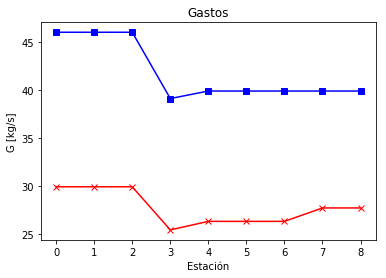

In [24]:
plt.figure()
plt.plot([G1, G1, G2, G3, G4, G5, G6, G7, G9], '-sb')
plt.plot([G1_pc, G1_pc, G2_pc, G3_pc, G4_pc, G5_pc, G6_pc, G7_pc, G9_pc], '-xr')
plt.title('Gastos')
plt.xlabel('Estación')
plt.ylabel('G [kg/s]')
plt.show()

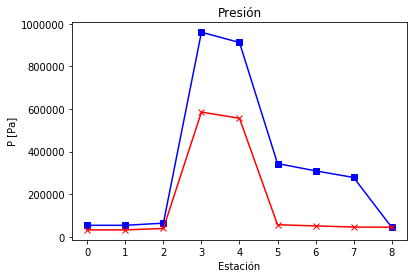

In [25]:
plt.figure()
plt.plot([p0t, p1t, p2t, p3t, p4t, p5t, p6t, p7t, p9], '-sb')
plt.plot([p0t_pc, p1t_pc, p2t_pc, p3t_pc, p4t_pc, p5t_pc, p6t_pc, p7t_pc, p9_pc], '-xr')
plt.title('Presión')
plt.xlabel('Estación')
plt.ylabel('P [Pa]')
plt.show()

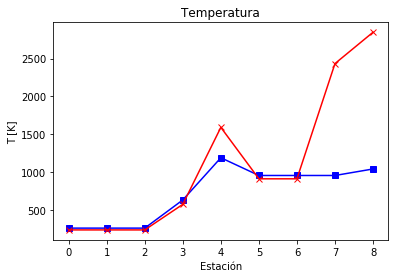

In [26]:
plt.figure()
plt.plot([T0t, T1t, T2t, T3t, T4t, T5t, T6t, T7t, T9t], '-sb')
plt.plot([T0t_pc, T1t_pc, T2t_pc, T3t_pc, T4t_pc, T5t_pc, T6t_pc, T7t_pc, T9t_pc], '-xr')
plt.title('Temperatura')
plt.xlabel('Estación')
plt.ylabel('T [K]')
plt.show()

In [27]:
print('Comparación empujes: E={0:2.1f}kN, Epc={1:2.1f}kN'.format(E/1e3, E_pc/1e3))
print('Comparación impulsos: Isp={0:2.1f}m/s, Isppc={1:2.1f}m/s'.format(Isp, Isp_pc))
print('Comparación consumos específicos: cE={0:1.4e}kg/s/N, Isppc={1:1.4e}kg/s/N'.format(cE, cE_pc))
print('Comparación consumos: c={0:2.3f}kg/s, cpc={1:2.3f}kg/s'.format(c, c_pc))
print('Comparación rendimiento motopropulsor: eta_mp={0:1.3f}%, eta_mppc={1:1.3f}%'.format(eta_mp*100, eta_mp_pc*100))

Comparación empujes: E=30.5kN, Epc=40.8kN
Comparación impulsos: Isp=766.1m/s, Isppc=1471.3m/s
Comparación consumos específicos: cE=2.5593e-05kg/s/N, Isppc=5.3408e-05kg/s/N
Comparación consumos: c=0.782kg/s, cpc=1.395kg/s
Comparación rendimiento motopropulsor: eta_mp=18.247%, eta_mppc=7.992%
